## Importing required libraries

In [52]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# Question 1 (Direct Linear Transform)

---

### 1. For the given image calib-object.jpg , use any 20-30 different points on different planes and perform the Direct Linear Transform (DLT) based calibration as discussed in class. Note that you need to manually estimate the image co-ordinates of the given world points and refer to calib-object-legend.jpg for world measurements.

##### Manually found image coordinates and their corresponding world points

Number of image coordinates: 26
Number of corresponding world coordinates: 26


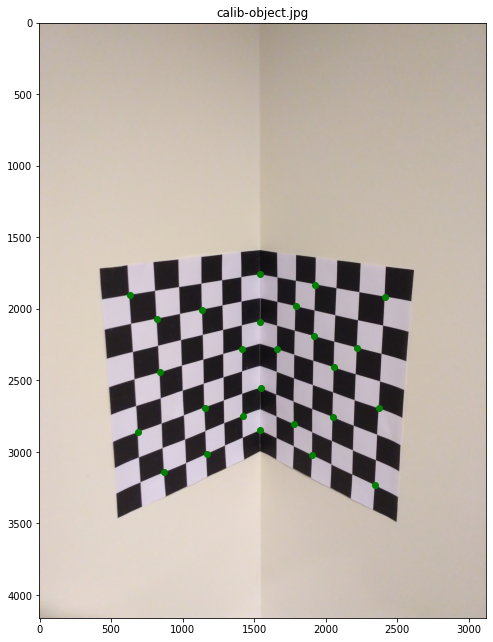

In [53]:
image_coord = np.array([
    [1544, 1760],
    [630, 1904],
    [822, 2070],
    [1138, 2006],
    [841, 2444],
    [1418, 2280],
    [690, 2861],
    [1154, 2690],
    [1420, 2749],
    [1168, 3015],
    [872, 3143],
    [1544, 2089],
    [1545, 2553],
    [1542, 2850],
    [1790, 1982],
    [1928, 1831],
    [2413, 1915],
    [2218, 2272],
    [1918, 2192],
    [1662, 2281],
    [2058, 2409],
    [2371, 2695],
    [2049, 2757],
    [1779, 2806],
    [1906, 3022],
    [2343, 3232]
])

world_coord = np.array([
    [0, 0, 1],
    [0, 6, 1],
    [0, 5, 2],
    [0, 3, 2],
    [0, 5, 4],
    [0, 1, 4],
    [0, 6, 6],
    [0, 3, 6],
    [0, 1, 7],
    [0, 3, 8],
    [0, 5, 8],
    [0, 0, 3],
    [0, 0, 6],
    [0, 0, 8],
    [2, 0, 2],
    [3, 0, 1],
    [6, 0, 1],
    [5, 0, 3],
    [3, 0, 3],
    [1, 0, 4],
    [4, 0, 4],
    [6, 0, 5],
    [4, 0, 6],
    [2, 0, 7],
    [3, 0, 8],
    [6, 0, 8]
])

print('Number of image coordinates:', image_coord.shape[0])
print('Number of corresponding world coordinates:', world_coord.shape[0])

world_coord_scale_a = world_coord * 28
world_coord_scale_b = world_coord * 2800

im = cv2.imread('../calibration-data/calib-object.jpg')
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.title("calib-object.jpg")
plt.show()

**_Helper functions_**

In [54]:
def DLT(image, world):
    G = []
    for i in range(image.shape[0]):
        X_i = world[i][0]
        Y_i = world[i][1]
        Z_i = world[i][2]
    
        u_i = image[i][0]
        v_i = image[i][1]
        
        G.append([X_i, Y_i, Z_i, 1, 0, 0, 0, 0, -u_i*X_i, -u_i*Y_i, -u_i*Z_i, -u_i])
        G.append([0, 0, 0, 0, X_i, Y_i, Z_i, 1, -v_i*X_i, -v_i*Y_i, -v_i*Z_i, -v_i])

    U, S, Vh = np.linalg.svd(G)
    
    P = Vh[-1, :] / (Vh[-1, -1] + 1e-8)
    P = P.reshape(3, 4)
    
    return P

In [55]:
def reconstruct(P, X, x):
    error = 0
    projected_points = []
    
    for i in range(X.shape[0]):
        x_calc = P @ np.append(X[i], 1)
        x_calc /= x_calc[2]+1e-8
        
        projected_points.append(x_calc[:2])
        error += np.mean(np.square(x[i] - x_calc[:2]))
    
    return error, np.array(projected_points)

In [56]:
def normalize(X, x):
    x = np.hstack((x, np.ones((x.shape[0], 1))))
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    x_ = np.mean(x[:, 0])
    y_ = np.mean(x[:, 1])
    d_ = np.mean(np.sqrt((x[:, 0] - x_)**2 + (x[:, 1] - y_)**2))
    r2 = np.sqrt(2)
    
    T_im = np.array([
        [r2/d_, 0, -r2*x_/d_],
        [0, r2/d_, -r2*y_/d_],
        [0, 0, 1]
    ])
    
    X_ = np.mean(X[:, 0])
    Y_ = np.mean(X[:, 1])
    Z_ = np.mean(X[:, 2])
    D_ = np.mean(np.sqrt((X[:, 0] - X_)**2 + (X[:, 1] - Y_)**2 + (X[:, 2] - Z_)**2))
    r3 = np.sqrt(3)
    
    T_world = np.array([
        [r3/D_, 0, 0, -r3*X_/D_],
        [0, r3/D_, 0, -r3*Y_/D_],
        [0, 0, r3/D_, -r3*Z_/D_],
        [0, 0, 0, 1]
    ])
    
    x_norm = (T_im @ x.T).T
    X_norm = (T_world @ X.T).T

    return X_norm[:, :3], x_norm[:, :2], T_im, T_world

#### (a). Use original data points as input.
#### Perform reconstruction on the original data points.

* Scale of each chessblock = (28x28mm)

Projection matrix:

 [[ 2.41258222e+00 -6.18307281e+00  5.81495256e-01  1.54121357e+03]
 [-1.29828572e+00 -1.28934981e+00  6.66254548e+00  1.59254751e+03]
 [-1.16629743e-03 -1.13010315e-03  3.68931760e-04  1.00002216e+00]]


Reconstruction error: 79.44386529340458


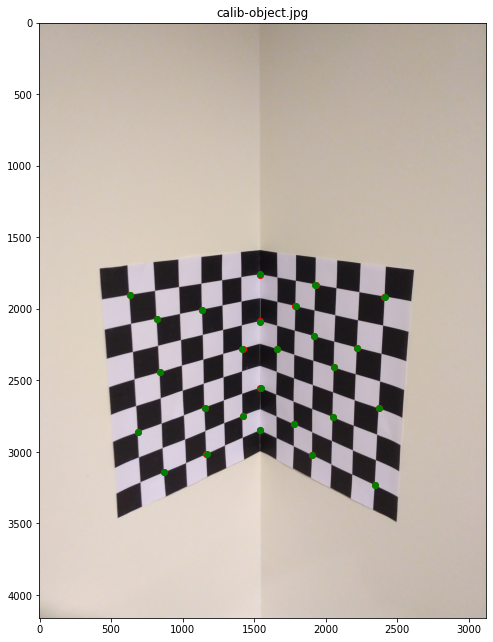

In [57]:
P_main = DLT(image_coord, world_coord_scale_a)
print('Projection matrix:\n\n', P_main)

error, projected_points = reconstruct(P_main, world_coord_scale_a, image_coord)
print('\n\nReconstruction error:', error)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("calib-object.jpg")
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

* Scale of each chessblock = (2800x2800mm)

Projection matrix:

 [[ 2.41258222e+00 -6.18307281e+00  5.81495256e-01  1.54121357e+03]
 [-1.29828572e+00 -1.28934981e+00  6.66254548e+00  1.59254751e+03]
 [-1.16629743e-03 -1.13010315e-03  3.68931760e-04  1.00002216e+00]]


Reconstruction error: 79.44386529340458


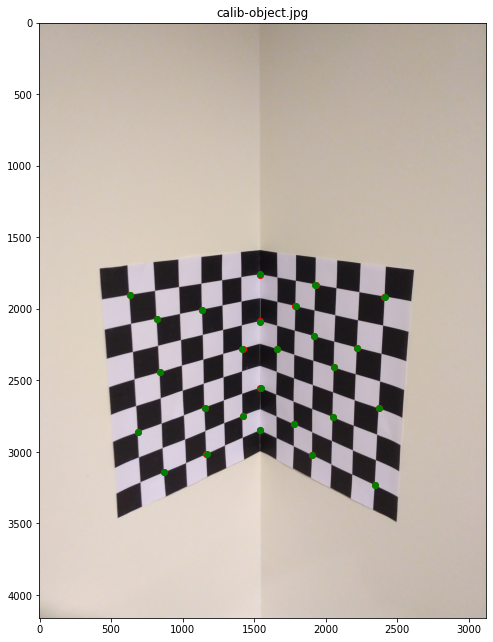

In [58]:
P = DLT(image_coord, world_coord_scale_a)
print('Projection matrix:\n\n', P)

error, projected_points = reconstruct(P, world_coord_scale_a, image_coord)
print('\n\nReconstruction error:', error)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("calib-object.jpg")
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

#### (b). Use normalized data points as input.
#### Perform reconstruction on the normalized data points (without denormalizing the projection matrix obtained)

* Scale of each chessblock = (28x28mm)

Projection matrix:

 [[ 6.22210841e-01 -6.47164876e-01  4.63410045e-04 -2.97857926e-03]
 [ 2.29455333e-01  2.17730774e-01  8.44595222e-01  1.56454561e-02]
 [-7.49930763e-02 -7.26610094e-02  2.37655826e-02  1.00000002e+00]]


Reconstruction error: 0.00041291438646017984


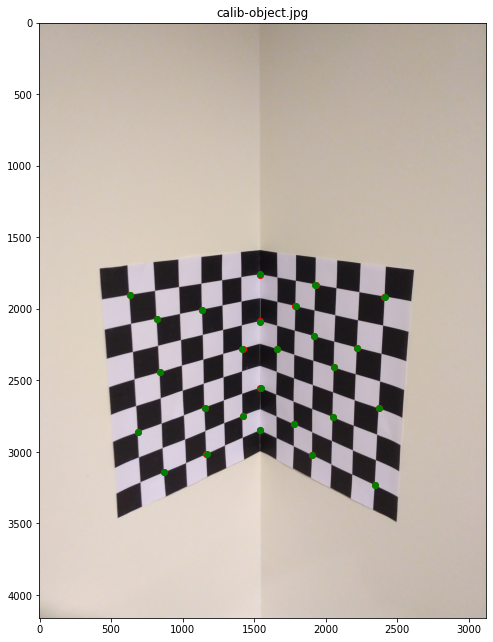

In [59]:
X_norm, x_norm, T_im, _ = normalize(world_coord_scale_a, image_coord)

P = DLT(x_norm, X_norm)
print('Projection matrix:\n\n', P)

error, projected_points = reconstruct(P, X_norm, x_norm)
print('\n\nReconstruction error:', error)

denorm_points = []
n = projected_points.shape[0]
for i in range(n):
    denorm_points.append(np.linalg.inv(T_im) @ np.append(projected_points[i], 1))
denorm_points = np.array(denorm_points)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("calib-object.jpg")
plt.plot(denorm_points[:, 0], denorm_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

* Scale of each chessblock = (2800x2800mm)

Projection matrix:

 [[ 6.22210841e-01 -6.47164876e-01  4.63410045e-04 -2.97857926e-03]
 [ 2.29455333e-01  2.17730774e-01  8.44595222e-01  1.56454561e-02]
 [-7.49930763e-02 -7.26610094e-02  2.37655826e-02  1.00000002e+00]]


Reconstruction error: 0.0004129143864601819


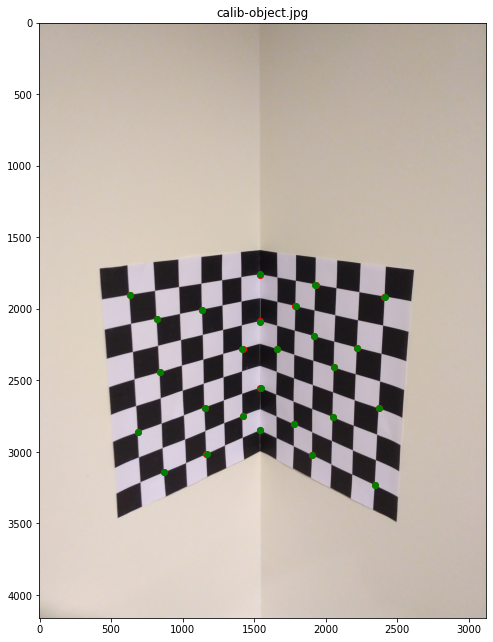

In [60]:
X_norm, x_norm, T_im, _ = normalize(world_coord_scale_b, image_coord)

P = DLT(x_norm, X_norm)
print('Projection matrix:\n\n', P)

error, projected_points = reconstruct(P, X_norm, x_norm)
print('\n\nReconstruction error:', error)

denorm_points = []
n = projected_points.shape[0]
for i in range(n):
    denorm_points.append(np.linalg.inv(T_im) @ np.append(projected_points[i], 1))
denorm_points = np.array(denorm_points)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("calib-object.jpg")
plt.plot(denorm_points[:, 0], denorm_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

#### (c). Use normalized data points as input.
#### Perform reconstruction on the original data points (with the denormalized projection matrix).

* Scale of each chessblock = (28x28mm)

Projection matrix:

 [[ 6.22210841e-01 -6.47164876e-01  4.63410045e-04 -2.97857926e-03]
 [ 2.29455333e-01  2.17730774e-01  8.44595222e-01  1.56454561e-02]
 [-7.49930763e-02 -7.26610094e-02  2.37655826e-02  1.00000002e+00]]

Denormalized projection matrix:

 [[ 2.55681993e+00 -6.54780393e+00  6.16713829e-01  1.63218012e+03]
 [-1.37306941e+00 -1.36350442e+00  7.05805430e+00  1.68643977e+03]
 [-1.23452831e-03 -1.19613807e-03  3.91226578e-04  1.05906094e+00]]


Reconstruction error: 79.42679049027666


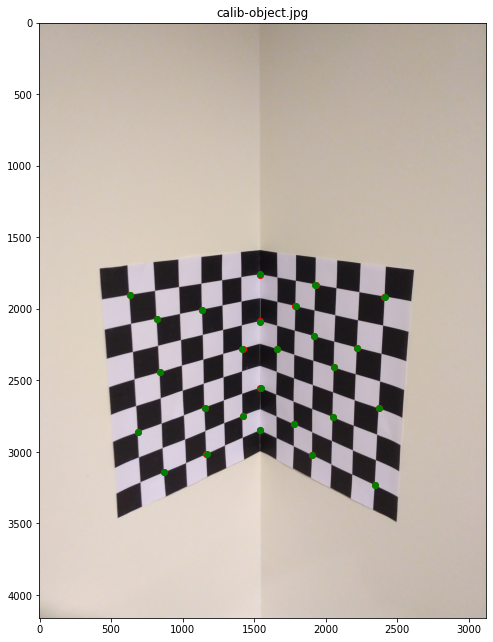

In [61]:
X_norm, x_norm, T_im, T_world = normalize(world_coord_scale_a, image_coord)

P = DLT(x_norm, X_norm)
print('Projection matrix:\n\n', P)

P_denorm = np.linalg.inv(T_im) @ P @ T_world
print('\nDenormalized projection matrix:\n\n', P_denorm)

error, projected_points = reconstruct(P_denorm, world_coord_scale_a, image_coord)
print('\n\nReconstruction error:', error)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("calib-object.jpg")
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

* Scale of each chessblock = (2800x2800mm)

Projection matrix:

 [[ 6.22210841e-01 -6.47164876e-01  4.63410045e-04 -2.97857926e-03]
 [ 2.29455333e-01  2.17730774e-01  8.44595222e-01  1.56454561e-02]
 [-7.49930763e-02 -7.26610094e-02  2.37655826e-02  1.00000002e+00]]
Denormalized projection matrix:

 [[ 2.55681993e-02 -6.54780393e-02  6.16713829e-03  1.63218012e+03]
 [-1.37306941e-02 -1.36350442e-02  7.05805430e-02  1.68643977e+03]
 [-1.23452831e-05 -1.19613807e-05  3.91226578e-06  1.05906094e+00]]


Reconstruction error: 79.42679049027352


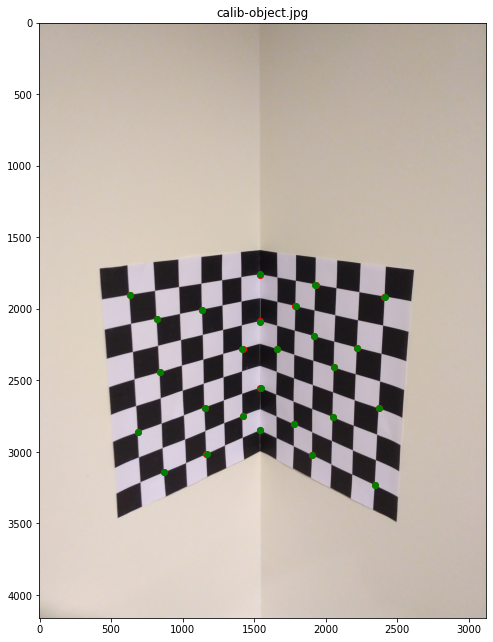

In [62]:
X_norm, x_norm, T_im, T_world = normalize(world_coord_scale_b, image_coord)

P = DLT(x_norm, X_norm)
print('Projection matrix:\n\n', P)

P_denorm = np.linalg.inv(T_im) @ P @ T_world
print('Denormalized projection matrix:\n\n', P_denorm)

error, projected_points = reconstruct(P_denorm, world_coord_scale_b, image_coord)
print('\n\nReconstruction error:', error)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("calib-object.jpg")
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

### **Observations**

* For all cases, the projection matrix and reconstruction error is exactly same for both scales, which means they are independent of scale
* For case a and c, the reconstruction error is larger than that in case b. This is because we normalized data points in case b and calculated the error also on normalized points. This is because normalization reduces the coordinate values which in turn reduces reconstruction error.
* For case a and c, the reconstruction error is almost same (with diff of ~0.2). This is because when we calculate projection matrix (P) using normalized points and then compute reconstruction error using denormalised projection matrix (P), the effect of normalization goes away

### 1.2 Decompose the projection matrix obtained for the main experiment above and report:
* camera matrix (K)
* rotation matrix (R)
* projection center (C)

In [63]:
P_main = DLT(image_coord, world_coord_scale_a)
print('Projection matrix:\n\n', P_main)

M = P[:, :3]
p = P[:, -1]

C = -np.linalg.inv(M) @ p

q, r = np.linalg.qr(np.linalg.inv(M))
K = np.linalg.inv(r)
K /= K[-1, -1]
R = q.T

print('\nCamera matrix:\n\n', K)
print('\nRotation matrix:\n\n', R)
print('\nProjection centre:\n\n', C)

Projection matrix:

 [[ 2.41258222e+00 -6.18307281e+00  5.81495256e-01  1.54121357e+03]
 [-1.29828572e+00 -1.28934981e+00  6.66254548e+00  1.59254751e+03]
 [-1.16629743e-03 -1.13010315e-03  3.68931760e-04  1.00002216e+00]]

Camera matrix:

 [[-8.38305468 -0.02794718  0.03253825]
 [-0.         -8.34559626 -1.12969696]
 [ 0.          0.          1.        ]]

Rotation matrix:

 [[-0.69525938  0.71874993  0.0035958 ]
 [-0.16194505 -0.15177421 -0.97505815]
 [-0.70027723 -0.67850064  0.22192044]]

Projection centre:

 [ 6.36205296  6.10975726 -3.32198731]


The diagonal elements are already negative. Hence the correction of K and R matrices is not required. If the diagonal elements are positive, then it indicates positive camera constant. To fix it, we do,
$$ K' = KR(z, \pi) $$
$$ R' = R(z, \pi)R $$

However, let's show that decomposition still holds true with these transformed matrices.

We know that $$ P = [KR | -KRC] $$

Suppose the obtained K and R are corrected, we get K' and R', hence the the projection matrix with these is,
$$ P' = [K'R' | -K'R'C] $$
$$ P' = [KR(z, \pi)R(z, \pi)R | -KR(z, \pi)R(z, \pi)RC] $$
$$ P' = [KR | -KRC] $$
$$ P' = P $$

Note: $$ R(z, \pi)R(z, \pi) = I $$
Because, rotation about z axis twice with 180 degress is equivalent to rotation of 360 degress.

Hence, we get back the same the projection matrix (P). Hence the decomposition of projection matrix (P) holds even after applying transformations.

### 1.3 (a) Implement the RANSAC based variant of the above calibration method and report your observations for main experiment.

In [64]:
def RANSAC(world_coord, image_coord, iters, thresh):
    max_inliers = 0
    best_err = 0
    P_out = np.zeros((3, 4))
    
    for i in range(iters):
        ind = np.random.randint(0, world_coord.shape[0], 6)
        sample_wc = world_coord[ind]
        sample_ic = image_coord[ind]
        P = DLT(sample_ic, sample_wc)
        
        err_sum = 0
        inliers = 0
        for j in range(world_coord.shape[0]):
            wc = world_coord[j:j+1]
            ic = image_coord[j:j+1]
            
            err, _ = reconstruct(P, wc, ic)
            err_sum += err
            if err < thresh:
                inliers += 1
        
        if inliers > max_inliers:
            P_out = P
            best_err = err_sum / world_coord.shape[0]
            max_inliers = inliers
            
    return P_out, best_err, max_inliers

In [65]:
P, err, inliers = RANSAC(world_coord_scale_a, image_coord, 100, 10)
print('Projection matrix:\n\n', P)
print('\nBest error:', err)
print('\nNumber of inliers:', inliers)

Projection matrix:

 [[ 2.44170854e+00 -6.16134949e+00  5.63792745e-01  1.54159066e+03]
 [-1.28848314e+00 -1.31816899e+00  6.68223108e+00  1.59114438e+03]
 [-1.16087352e-03 -1.13607812e-03  3.69657865e-04  9.99977845e-01]]

Best error: 6.4678315062247735

Number of inliers: 22


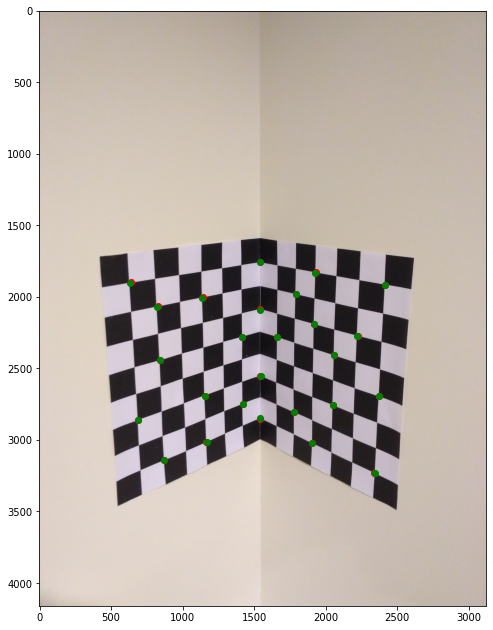

In [66]:
_, projected_points = reconstruct(P, world_coord_scale_a, image_coord)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_coord[:, 0], image_coord[:, 1], 'go')
plt.show()

#### Observations for RANSAC based variant

* The error is significantly reduced compared to that of DLT
* Many outlier points are rejected due to calculation of projection matrix on minimum required number of points (6)

### 1.3 (b). RANSAC is said to be successful if in atleast 1 of the iterations, it selects only inliers (correct correspondences) from the input data points. Assume that your accuracy for annotating the points for the above experiment is 80%. What is the minimum number of iterations you will have to run RANSAC for getting probability of success greater than 95%?

**Given**
* Accuracy for annotating the points (1-e): 80%
* Prabability of success (p): >95%
* Number of sampled points (s): 6
* Number of iterations (T): ?

As we want $$ p > 0.95$$
$$ \implies (1-p) < 0.05$$
$$ \implies log(1-p) < log(0.05) = -1.30103 $$

The equation which related e, p, s and T is as follows,
$$ 1-p = (1-(1-e)^s)^T $$

Applying log on both sides,
$$ log(1-p) = T*log(1-(1-e)^s) $$

As log(1-p) < -1.30103,
$$ T*log(1-(1-e)^s) < -1.30103 $$
$$ T*log(1-0.8^6) < -1.30103 $$
$$ T*log(0.737856) < -1.30103 $$
$$ T*(-0.132028387) < -1.30103 $$
$$ T > 9.85416871 $$

Hence, minimum number of iterations (**T**) required to run RANSAC to get probability of success greater than **95%** with accuracy for annotating the points with **80%** is **10 iterations**

### 1.3 (c) Assuming the same accuracy, plot a curve of Probability of success of RANSAC vs Number of iterations required.

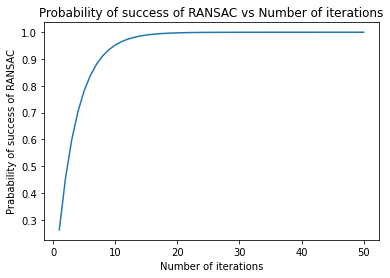

In [67]:
accuracy = 0.8
sample_size = 6

iterations = np.arange(50)+1
succ_prob = []

for i in iterations:
    prob = 1 - (1 - accuracy**sample_size)**i
    succ_prob.append(prob)

plt.plot(iterations, succ_prob)
plt.ylabel('Prabability of success of RANSAC')
plt.xlabel('Number of iterations')
plt.title('Probability of success of RANSAC vs Number of iterations')
plt.show()

The above graph shows the exponential nature of the **probability of success** vs **number of iterations** graph. Hence, the probability of success increases exponentially with each iteration.

# Question 2 (Zhang's method)

---

### Use checkerboard images IMG5456.JPG - IMG5470.JPG and perform camera calibration using Zhang’s Method. For this part you can use inbuilt cv2 functions.

In [68]:
world_points = []
image_points = []

world = np.zeros((48, 3), np.float32)
world[:, 0:1] = np.meshgrid(range(8), range(6))[0].reshape(-1, 1) * 29
world[:, 1:2] = np.meshgrid(range(8), range(6))[1].reshape(-1, 1) * 29

for i in range(15):
    img_file = "../calibration-data/IMG_54"+str(56+i)+".JPG"
    im = cv2.imread(img_file)
    
    ret, corners = cv2.findChessboardCorners(im, (8, 6), None)
    
    if ret:
        world_points.append(world)
        image_points.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_points, image_points, (im.shape[0], im.shape[1]), None, None)

print('Reprojection error:', ret)
print('\nCamera calibration matrix:\n\n', mtx)
print('\nDistortion coefficients:\n\n', dist)

Reprojection error: 2.5682466775102952

Camera calibration matrix:

 [[1.35154538e+04 0.00000000e+00 2.40937297e+03]
 [0.00000000e+00 1.35727472e+04 2.16925322e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients:

 [[ 3.61213290e-01 -3.90429548e+00  1.72898074e-02 -1.58538386e-02
   4.70415001e+01]]


### Using the estimated camera parameters compute the image points and overlay a wireframe over the actual image of chessboard using straight lines between the computed points. Refer to example-wireframe.png for reference. What do you observe about the overlay?

In [69]:
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

In [70]:
def projection_matrix(K, r, t):
    R = eulerAnglesToRotationMatrix(r)
    tmp = np.hstack((R, t[:, 0:1]))
    
    P = K@tmp
    P /= P[-1, -1]
    
    return P

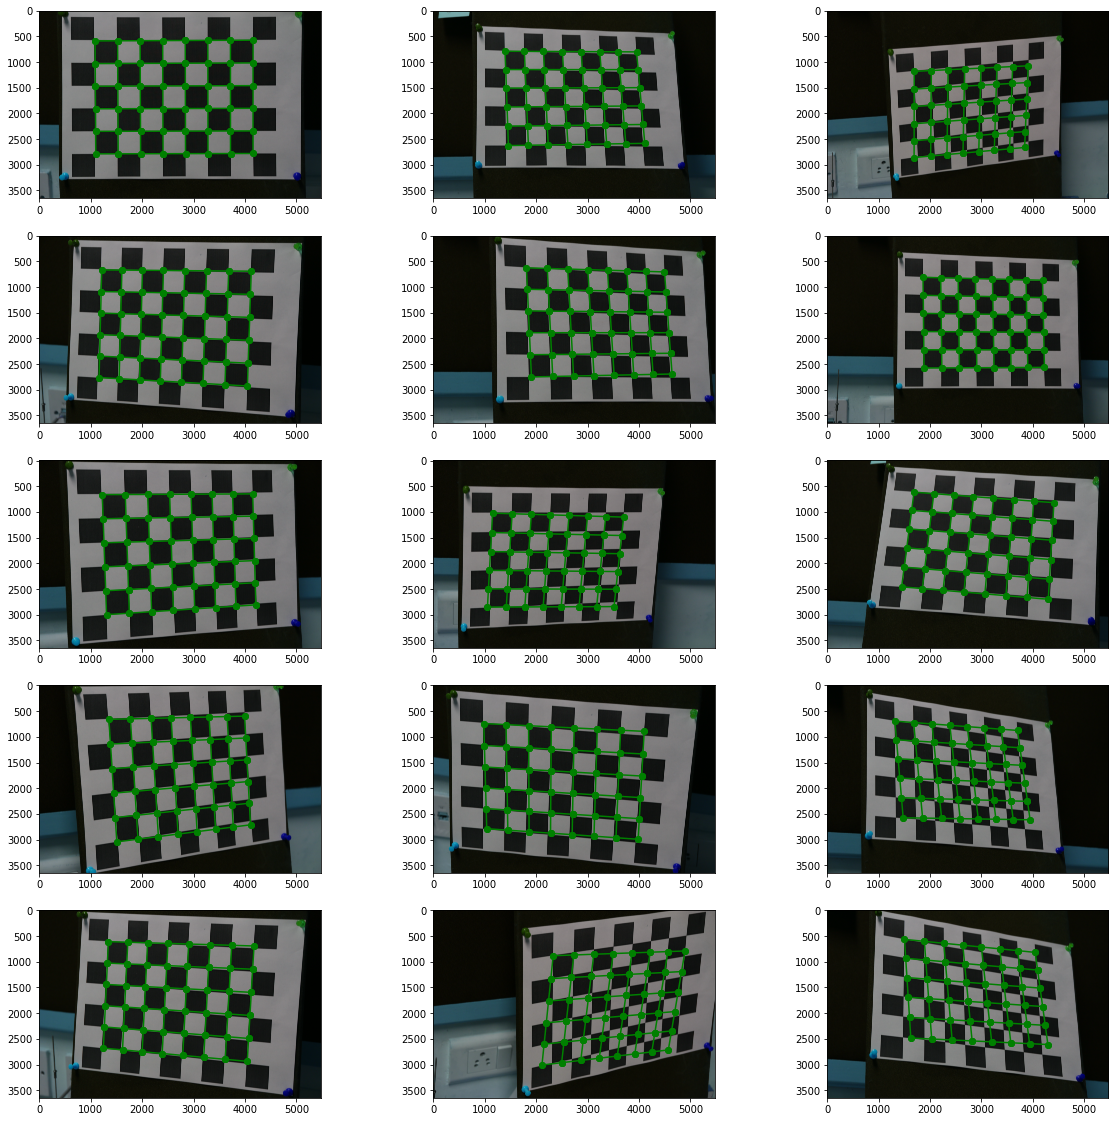

In [71]:
world_points = np.hstack((world, np.ones((48, 1))))
fig, axs = plt.subplots(5, 3, figsize=(20, 20))

for i in range(15):
    a = i % 5
    b = i // 5
    img_file = "../calibration-data/IMG_54"+str(56+i)+".JPG"
    im = cv2.imread(img_file)
    
    P = projection_matrix(mtx, rvecs[i], tvecs[i])
    
    tmp = (P @ world_points.T).T
    projected_points = tmp / tmp[:, 2:3]
    
    for j in range(48):
        c = j // 8
        d = j % 8
        if j % 8 != 7:
            x = [projected_points[j, 0], projected_points[j+1, 0]]
            y = [projected_points[j, 1], projected_points[j+1, 1]]
            axs[a][b].plot(x, y, 'go-')
        
        if j // 8 != 5:
            x = [projected_points[j, 0], projected_points[j+8, 0]]
            y = [projected_points[j, 1], projected_points[j+8, 1]]
            axs[a][b].plot(x, y, 'go-')
            
    axs[a][b].imshow(im)

### **Observations about the overlay**

* For some images which are not perpendicular to camera's principal axis, the rotation and translation matrices are not computed correctly which makes the wireframe not to fit properly when overlayed. For rest of the images, the wireframe fits exactly
* There could be some distortion in the images which lead to little unfitting of overlays

# Question 3 (DIY)

---

### Perform the above DLT using the an image taken by your camera. Use a calibration object for which you can measure the world co-ordinates. Try the RANSAC based variant as well, for the same, and compare results.

Number of image coordinates: 18
Number of corresponding world coordinates: 18


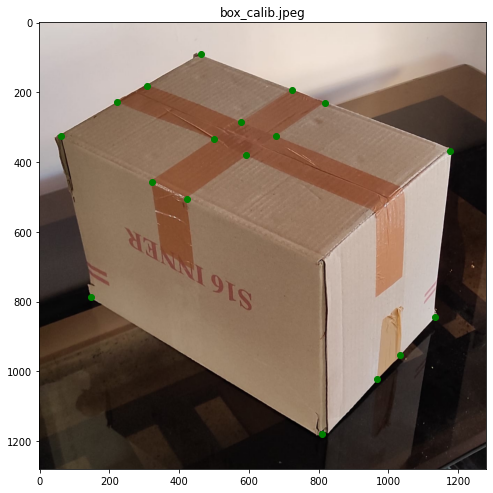

In [77]:
world_points = np.array([
    [0, 227, 233],
    [0, 0, 233],
    [350, 0, 233],
    [0, 227, 0],
    [350, 227, 0],
    [350, 0, 0],
    [208, 91, 0],
    [208, 136, 0],
    [160, 136, 0],
    [160, 88, 0],
    [180, 227, 0],
    [208, 227, 0],
    [350, 130, 0],
    [350, 84, 0],
    [208, 0, 0],
    [160, 0, 0],
    [0, 97, 233],
    [0, 142, 233]
])

image_points = np.array([
    [1134, 844],
    [811, 1180],
    [148, 786],
    [1178, 368],
    [463, 91],
    [60, 325],
    [500, 335],
    [577, 285],
    [677, 326],
    [592, 381],
    [817, 230],
    [723, 192],
    [309, 181],
    [223, 229],
    [322, 457],
    [424, 505],
    [968, 1023],
    [1034, 952]
])

print('Number of image coordinates:', image_points.shape[0])
print('Number of corresponding world coordinates:', world_points.shape[0])

im = cv2.imread('../images/box_calib.jpeg')
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.plot(image_points[:, 0], image_points[:, 1], 'go')
plt.title("box_calib.jpeg")
plt.show()

Projection matrix:

 [[ 2.41258222e+00 -6.18307281e+00  5.81495256e-01  1.54121357e+03]
 [-1.29828572e+00 -1.28934981e+00  6.66254548e+00  1.59254751e+03]
 [-1.16629743e-03 -1.13010315e-03  3.68931760e-04  1.00002216e+00]]


Reconstruction error: 854.9481246139164


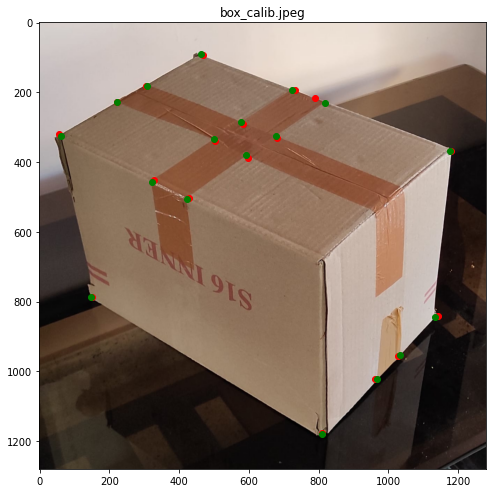

In [78]:
P = DLT(image_points, world_points)
print('Projection matrix:\n\n', P_main)

error, projected_points = reconstruct(P, world_points, image_points)
print('\n\nReconstruction error:', error)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.title("box_calib.jpeg")
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_points[:, 0], image_points[:, 1], 'go')
plt.show()

Projection matrix:

 [[-2.08896044e+00  2.63480887e+00  5.65806279e-01  8.00228872e+02]
 [-8.56651197e-01 -1.15680441e+00  2.89407762e+00  6.92864132e+02]
 [ 6.26084786e-04  9.09030551e-04  5.95191434e-04  1.00001059e+00]]

Best reconstruction error: 105.93644503563547

Number of inliers: 12


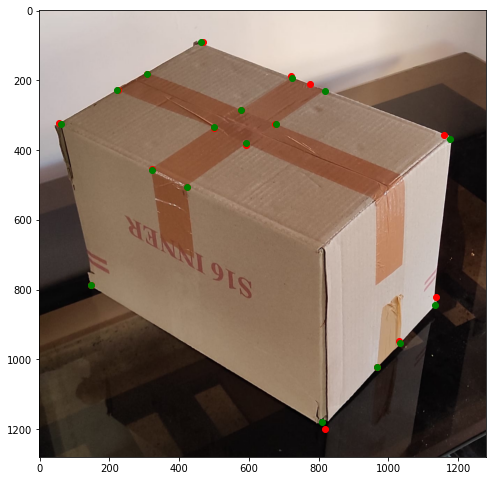

In [80]:
P, err, inliers = RANSAC(world_points, image_points, 1000, 10)
print('Projection matrix:\n\n', P)
print('\nBest reconstruction error:', err)
print('\nNumber of inliers:', inliers)

error, projected_points = reconstruct(P, world_points, image_points)

plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.plot(projected_points[:, 0], projected_points[:, 1], 'ro')
plt.plot(image_points[:, 0], image_points[:, 1], 'go')
plt.show()

### **Observations**

* The reconstruction error for RANSAC based approach is lower than DLT approach
* Except one point, all points are projected almost correctly. This could be a major outlier for higher reconstruction error
* As the data points are not normalised, the reconstruction error is high